# Topic modeling of brokers' remarks on the property
In this notebook I will use non-negative matrix factorization to determine the ten recurring topics for the houses.

In [17]:
import sys
sys.path.append('../functions')

import pandas as pd
import numpy as np
from nlp_functions import preprocess,plot_top_10_words_from_count,print_topics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF


property_type = 'condo'
df = pd.read_csv('../data/textdata/' + 'Boston_%s_remarks.csv'%property_type,index_col=0)

print(df['REMARKS'].iloc[0])

df_processed = df['REMARKS'].apply(lambda x: preprocess(x,pos_tag=['NNP','VBP']))

print(' ')
print(df_processed.iloc[0])





['The perfect blend of urban and city living in the heart of south Boston! Enjoy an abundant amount of sunlight in this Sun filled corner unit with amazing Skyline views! Open floor plan living room/dining room combo allows for perfect entertaining and relaxation. Updated kitchen features Cherry cabinets with SS appliances, engineered quartz counters, breakfast bar and stunning pendant lights. Enjoy the master suite with an over-sized bath just remodeled walk in shower and tile. Second bath features a Jacuzzi! Bedroom number 2 overlooks downtown Boston and has plenty of room for furniture and more. Deeded Garage space, Elevator in the building, Huge common roof deck with full 360 degree views! Conveniently located on a quiet street in Southie and seconds from downtown, shopping, restaurants and public transportation. Central A/C with garage parking make this one not to be missed!!']
 
 the perfect blend urban citi live heart south abund sunlight fill corner unit amaz view floor plan li

In [18]:
ngram = 1
tfidf_vectorizer = TfidfVectorizer(stop_words='english',
                                   analyzer='word',
                                   strip_accents='ascii',
                                   ngram_range=(ngram,ngram))

corpus_tfidf = tfidf_vectorizer.fit_transform(df_processed.astype(str)) # remove number, stop words, lemmatize, 
                                                                        # stemming, tokenize

n_topic = 10

nmf = NMF(n_components=n_topic, random_state=101).fit(corpus_tfidf)
nmf.fit(corpus_tfidf)

n_top_words = 10
print_topics(nmf, tfidf_vectorizer, n_top_words)

Topic #0: room, live, bedroom, din, larg, space, level, spaciou, storag, offic
Topic #1: custom, bath, master, marbl, closet, shower, featur, ga, suit, walkin
Topic #2: resid, servic, concierg, outdoor, pool, fit, hour, indoor, room, view
Topic #3: new, brand, renov, bathroom, tile, electr, plumb, paint, updat, unit
Topic #4: build, manag, profession, elev, common, area, window, ceil, avail, brick
Topic #5: offer, space, thi, complet, finish, unit, home, modern, ideal, provid
Topic #6: home, platinum, meet, bicycl, puls, captur, club, new, reflect, expand
Topic #7: home, includ, tile, walk, live, minut, area, prefinish, taxi, collect
Topic #8: condo, unit, locat, floor, thi, shop, hardwood, restaur, park, walk
Topic #9: deck, roof, view, privat, citi, penthous, skylin, common, panoram, right


Based on the collection of words, this is what I guess each topic (condo) is about:  
Topic 0: interior space on the house  
Topic 1: specifics of the master bedroom  
Topic 2: service and amenities  
Topic 3: renovated bathroom  
Topic 4: building management  
Topic 5: ???  
Topic 6: ???  
Topic 7: locality of the property, convenience  
Topic 8: locality of the property, convenience  
Topic 9: view of the top floor

Calculate the similarity of each remark to each of the ten topics

In [19]:
words = np.array(tfidf_vectorizer.get_feature_names())

topic_word_vectors = []
for i in range(n_topic):
    topic_word_vectors.append(words[nmf.components_[i].argsort()[:-n_top_words - 1:-1]])

    
def topic_similarity(remark):
    return [len(set(remark.split(' ')).intersection(set(topic_word_vectors[i])))/n_top_words
            for i in range(n_topic)]

df_topic_vector = df_processed.apply(topic_similarity)

print(df_topic_vector)



1       [0.3, 0.5, 0.2, 0.3, 0.2, 0.2, 0.0, 0.3, 0.7, ...
3       [0.7, 0.4, 0.1, 0.3, 0.1, 0.7, 0.1, 0.1, 0.8, ...
4       [0.3, 0.2, 0.2, 0.2, 0.8, 0.5, 0.1, 0.3, 0.5, ...
6       [0.6, 0.2, 0.2, 0.3, 0.1, 0.6, 0.0, 0.1, 0.5, ...
7       [0.3, 0.2, 0.2, 0.2, 0.2, 0.6, 0.0, 0.0, 0.8, ...
                              ...                        
9987    [0.2, 0.1, 0.2, 0.2, 0.0, 0.1, 0.0, 0.1, 0.4, ...
9989    [0.6, 0.1, 0.2, 0.2, 0.2, 0.4, 0.1, 0.3, 0.7, ...
9990    [0.6, 0.6, 0.0, 0.2, 0.4, 0.2, 0.0, 0.1, 0.4, ...
9991    [0.7, 0.2, 0.1, 0.2, 0.1, 0.4, 0.0, 0.1, 0.7, ...
9992    [0.1, 0.1, 0.0, 0.1, 0.1, 0.2, 0.0, 0.0, 0.5, ...
Name: REMARKS, Length: 5805, dtype: object


# Predictability
To see how useful the topics are to predict the selling price, I project the 10 topics on a two dimensional space using PCA and color the data by its selling price per square feet.

(5757, 10)


<IPython.core.display.Javascript object>


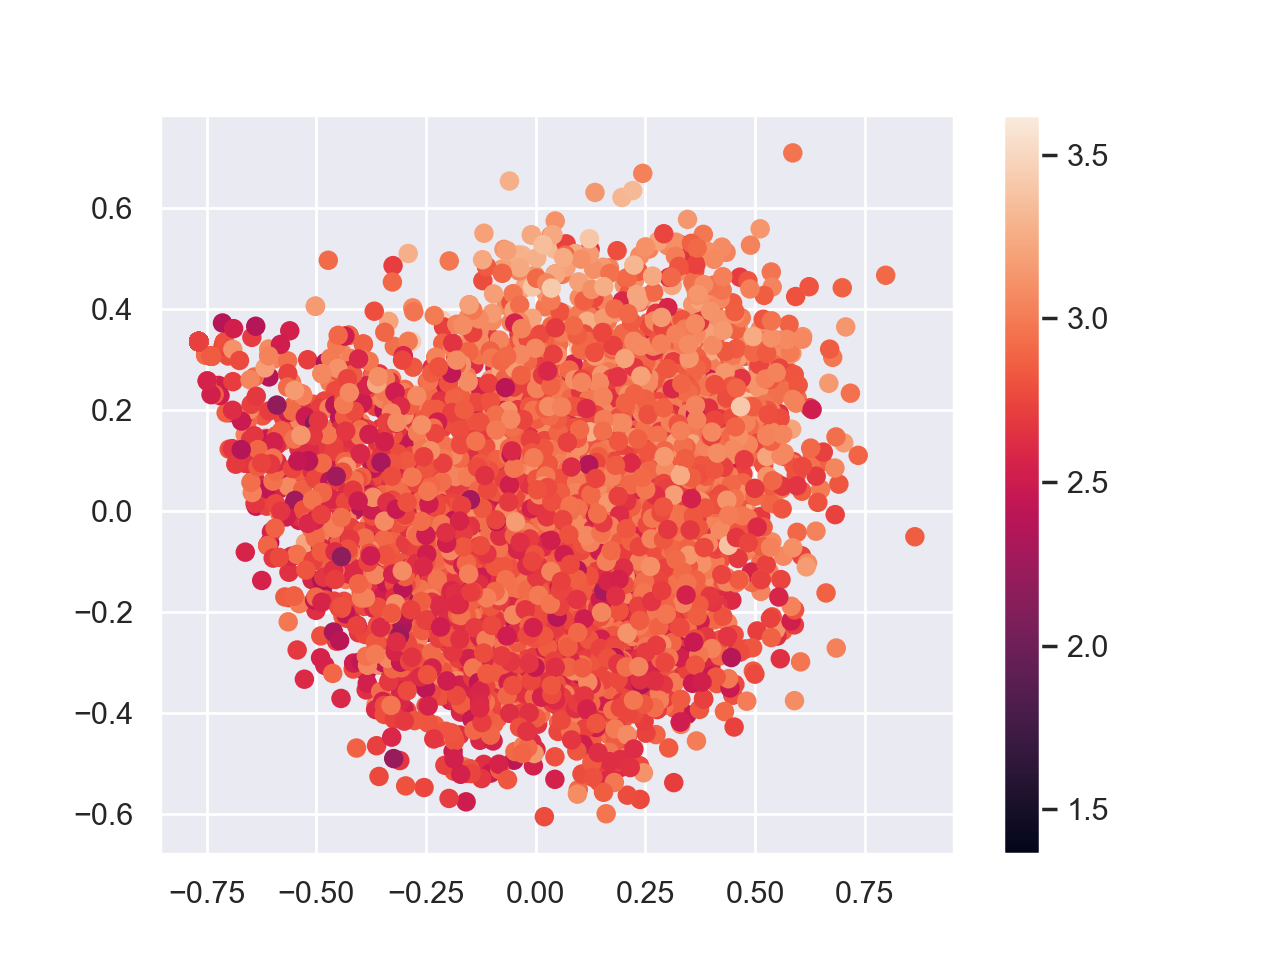

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns

sns.set()

df_master = pd.read_csv('../data/raw/' + 'redfin_2020-01-19-08-17-26.csv')
df_transaction = pd.read_csv('../data/processed/' + 'Boston_%s_transaction.csv'%property_type,index_col=0)

df_regr = df_master[['$/SQUARE FEET','YEAR BUILT']].join(df_topic_vector,how='inner')
df_regr = df_regr.join(df_transaction,how='inner')

df_regr['LIST DATE'] = pd.to_datetime(df_regr['LIST DATE'])
df_regr['SOLD DATE'] = pd.to_datetime(df_regr['SOLD DATE'])

df_regr['DAYS ON MKT'] = (df_regr['SOLD DATE'] - df_regr['LIST DATE']).apply(lambda x: x.days)

mask1 = df_regr['DAYS ON MKT'] > 0 # price history scraped after spreadsheet
mask2 = df_regr['LIST PRICE'] < 1e8 # one typo with list price = 1.6e8
mask = np.logical_and(mask1,mask2)

df_regr = df_regr[mask]

X = []
for i in range(len(df_regr)):
    X.append(df_regr['REMARKS'].iloc[i])
    
print(np.asarray(X).shape)

pca = PCA(n_components=2)
X_emb = pca.fit_transform(X)


fig = plt.figure()
plt.scatter(X_emb[:,0],X_emb[:,1],c=np.log10(df_regr['$/SQUARE FEET'].values))
plt.colorbar()
plt.show()


We see some degree of separation between the color in the 2D projected space, e.g. darker on the bottom left and brighter on the top right. While the separation is not strong, it is still very interesting since the text were cleaned and numerics were excluded (i.e. no size, age information). This means there are qualitative information in the text which can help determining the house price.
